# 5.0 Side Experiments

We have 81 features in total and we would like to use different models to guide us in the feature selection process.

## 5.1 Feature Importance Experiments

- Feature importance from model coefficients
- Feature importance from decision trees
- Feature importance from model agnostic approaches

### Setup and Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

aug_data3 = pd.read_csv("data/training-set-1/pose_data_augmented_res_z.csv")
aug_data3 = aug_data3.loc[:, ~aug_data3.columns.str.contains('_v')]
X = pd.concat([aug_data3.iloc[:, 5:8], aug_data3.iloc[:, 38:56], aug_data3.iloc[:, 74:92], aug_data3.iloc[:, 104:]],axis=1)
y = aug_data3['label_encoded'].values

feature_names = X.columns
importances = pd.DataFrame(index=feature_names)

## 2.2.1 Model Coefficients

### Logistic Regression Feature Importance

Weights from logistic regression coefficients help highlight key features by changing distances in the feature space, with larger coefficients indicating greater influence on a query point's class. Negative coefficients mean a feature has an opposite effect on the outcome compared to features with positive coefficients.

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


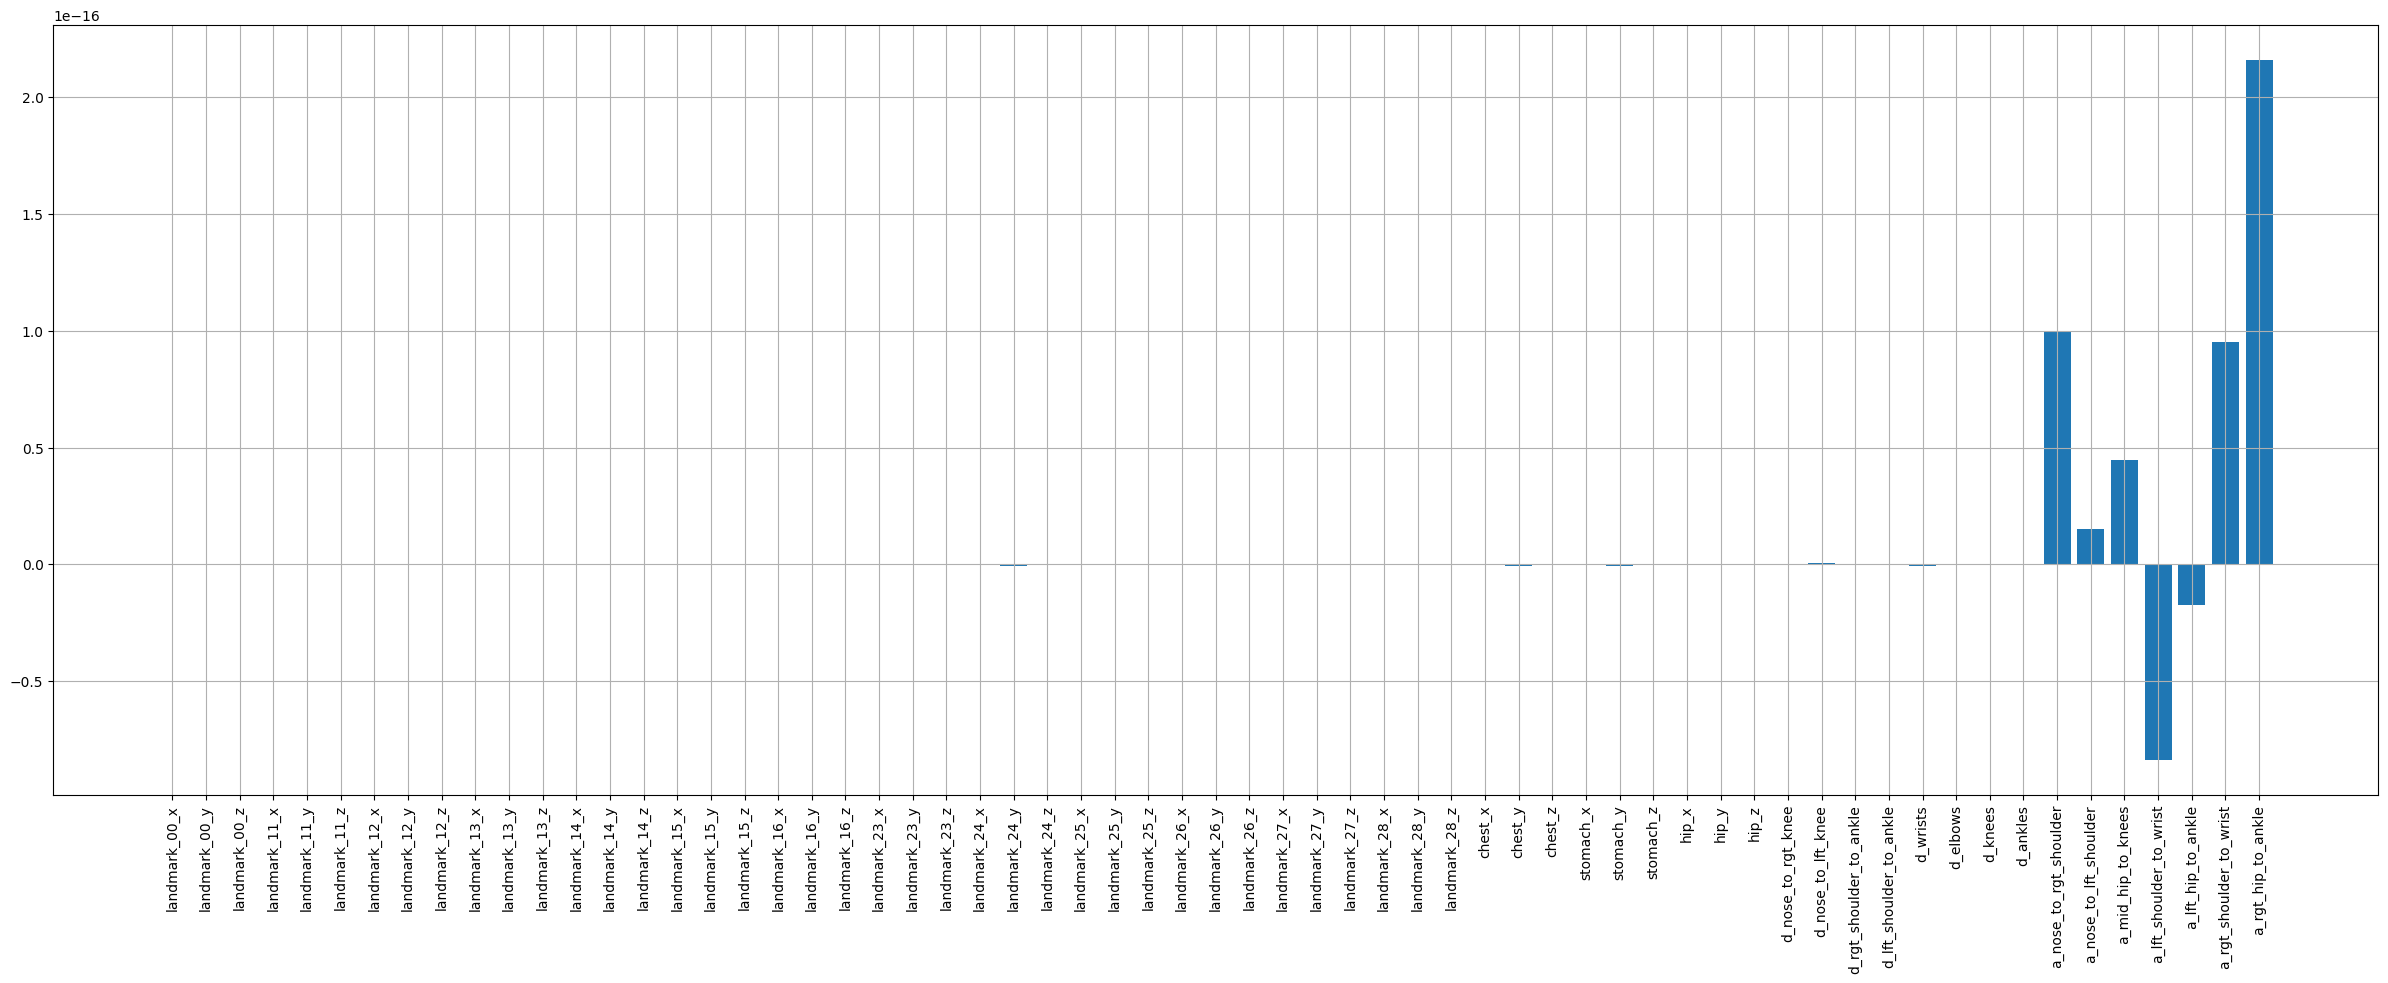

In [6]:
from sklearn.linear_model import LogisticRegression

logr_model = LogisticRegression(max_iter=10)
logr_model.fit(X, y)

importances['logr'] = np.mean(logr_model.coef_, axis=0)

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances['logr'])
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## 2.2.2 Decision Trees

### Gini Impurity 

In Decision Trees using Gini impurity, weights with higher values show a greater contribution to reducing uncertainty in classifying data by effectively splitting the dataset into purer nodes.

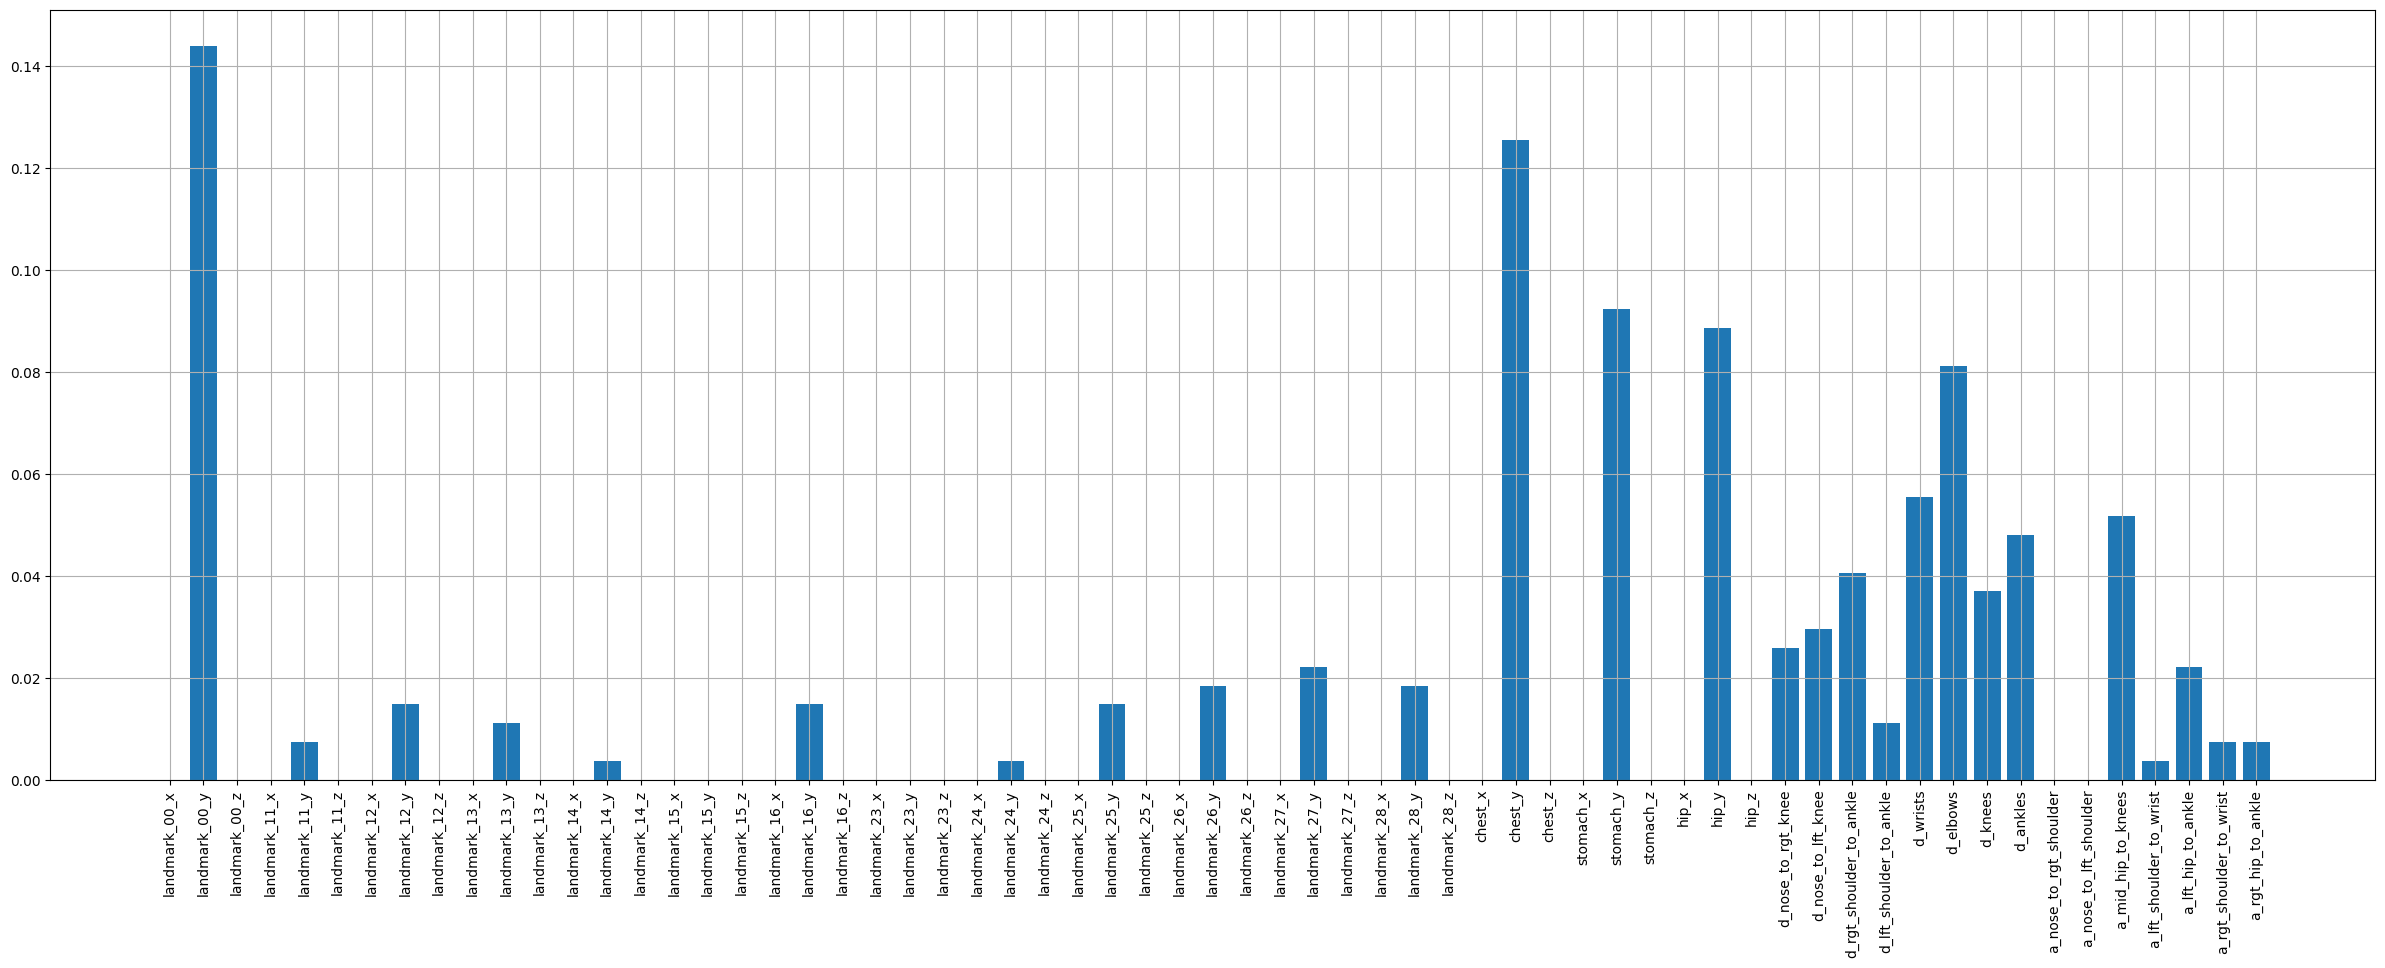

In [7]:
from sklearn.tree import DecisionTreeClassifier

gini_model = DecisionTreeClassifier(criterion='gini')
gini_model.fit(X, y)

importances['gini'] = gini_model.feature_importances_

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances['gini'])
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## 2.2.3 Model Agnostic Approaches

**Permutation Testing**: Weights derived from permutation feature importance represent how much the model's prediction accuracy relies on each feature. The more the accuracy decreases when a feature's values are shuffled, the more important that feature is deemed to be.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_64711/4213566575.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


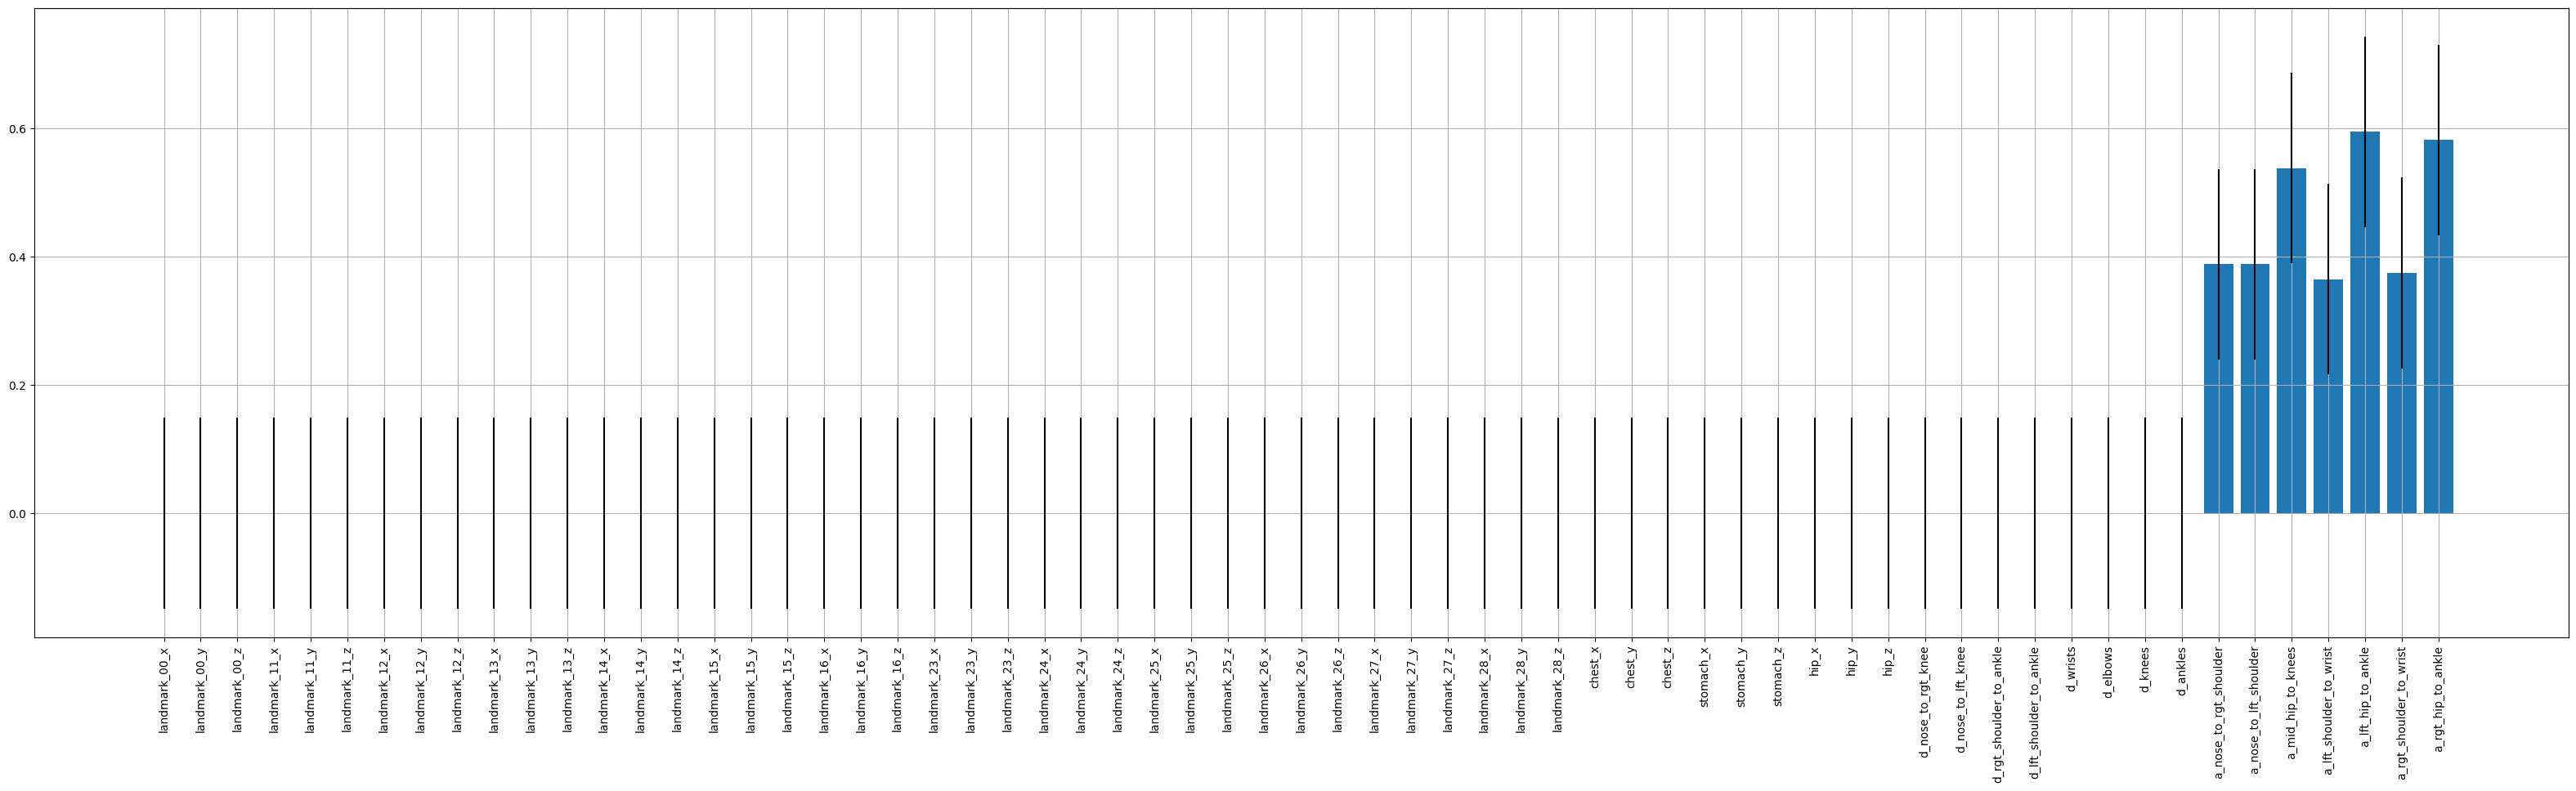

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

knn = KNeighborsClassifier()
Xs, _, ys, _ = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)
knn.fit(Xs, ys)
results = permutation_importance(knn, Xs, ys, scoring='accuracy', n_repeats=3, n_jobs=1)
importances['permutation'] = results.importances_mean

importances_std = np.std(importances['permutation'], axis=0)

fig, ax = plt.subplots(figsize=(40, 10))
ax.bar(feature_names, importances['permutation'], yerr=importances_std, align='center')
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True)
plt.show()

**SHAP Model**

PermutationExplainer explainer: 3918it [14:40,  4.43it/s]                                                                                      


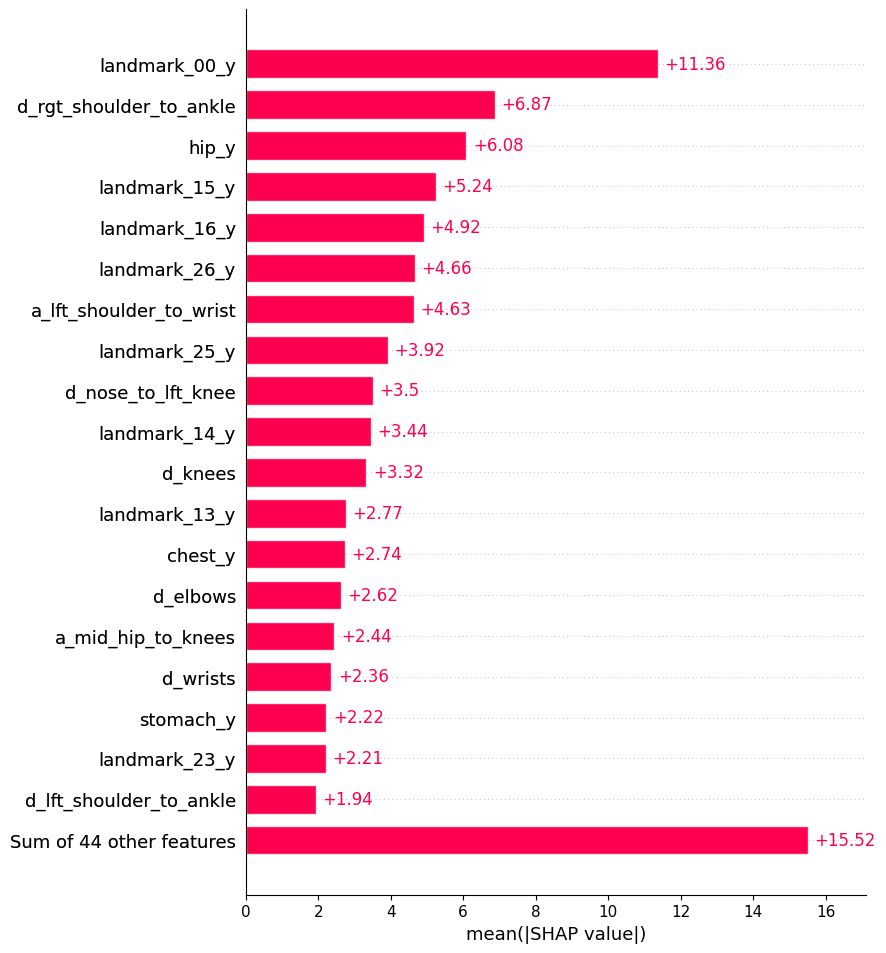

In [9]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = RandomForestRegressor()
model.fit(X_train, y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values1 = explainer(X_test)

shap.plots.bar(shap_values1, max_display=20)

In [10]:
feature_importances = np.abs(shap_values1.values).mean(axis=0)
feature_weights = feature_importances / np.sum(feature_importances)
importances['shap'] = feature_weights

## Compile Results

In [19]:
importances

,logr,gini,permutation,shap
landmark_00_x,-4.112374e-21,0.000000,0.000000,4.953707e-09
landmark_00_y,2.323860e-19,0.143911,0.000000,1.224771e-01
landmark_00_z,2.720274e-22,0.000000,0.000000,0.000000e+00
landmark_11_x,-6.564037e-22,0.000000,0.000000,0.000000e+00
landmark_11_y,-5.580452e-20,0.007380,0.000000,1.919675e-02
...,...,...,...,...
a_mid_hip_to_knees,4.449056e-17,0.051661,0.537990,2.635377e-02
a_lft_shoulder_to_wrist,-8.354097e-17,0.003690,0.364924,4.996163e-02
a_lft_hip_to_ankle,-1.750030e-17,0.022140,0.594771,1.891655e-02
a_rgt_shoulder_to_wrist,9.503989e-17,0.007380,0.374455,1.203547e-02


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
weights = pd.DataFrame(scaler.fit_transform(importances), columns=importances.columns)
weights

,logr,gini,permutation,shap
0,8.353685e-17,0.000000,0.000000,4.044599e-08
1,8.377335e-17,1.000000,0.000000,1.000000e+00
2,8.354124e-17,0.000000,0.000000,0.000000e+00
3,8.354031e-17,0.000000,0.000000,0.000000e+00
4,8.348516e-17,0.051282,0.000000,1.567375e-01
...,...,...,...,...
58,1.280315e-16,0.358974,0.904533,2.151731e-01
59,0.000000e+00,0.025641,0.613553,4.079264e-01
60,6.604067e-17,0.153846,1.000000,1.544497e-01
61,1.785809e-16,0.051282,0.629579,9.826712e-02


In [23]:
importances.to_csv("results/feature_weights_20240314.csv", index=False)

### Results

Across various feature importance metrics employed, a consistent pattern emerged: y-variables as predominantly influential in model predictions. This regularity suggests that the vertical dimensions of the images hold key discriminative information. Given that the dataset comprises images with a uniform aspect ratio and captured under similar conditions, it is reasonable to extrapolate that future datasets obtained in a like manner would exhibit a comparable hierarchy of feature importance. This underlines the significance of standardized image acquisition in ensuring the replicability of the model's interpretive patterns.

# Resources

1. https://machinelearningmastery.com/calculate-feature-importance-with-python/
2. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/